# 2025-11-10 Transformed Quadrature

* Singular integrals and Tanh-Sinh quadrature

* Finite element integration and mapped elements

* Adaptive integration

* Integration in multiple dimensions

In [16]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Vandermonde with Legendre polynomials
function vander_legendre(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, n)
    if n > 1
        Q[:, 2] = x
    end
    for k in 1:n-2
        Q[:, k+2] = ((2*k + 1) * x .* Q[:, k+1] - k * Q[:, k]) / (k + 1)
    end
    Q
end

# And a utility for points distributed via cos
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

# Some test functions
F_expx(x) = exp(2x) / (1 + x^2)
f_expx(x) = 2*exp(2x) / (1 + x^2) - 2x*exp(2x)/(1 + x^2)^2

F_dtanh(x) = tanh(x)
f_dtanh(x) = cosh(x)^-2

integrands = [f_expx, f_dtanh]
antiderivatives = [F_expx, F_dtanh]
tests = zip(integrands, antiderivatives)

# Plotting utils for accuracy
function plot_accuracy(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="n", ylabel="error")
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(ns, Errors, label=f)
    end
    for k in ref
        plot!(ns, ns.^(-1. * k), label="\$n^{-$k}\$")
    end
    p
end

plot_accuracy (generic function with 1 method)

## [FastGaussQuadrature.jl](https://juliaapproximation.github.io/FastGaussQuadrature.jl/stable/)

There are packages to help us here.

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


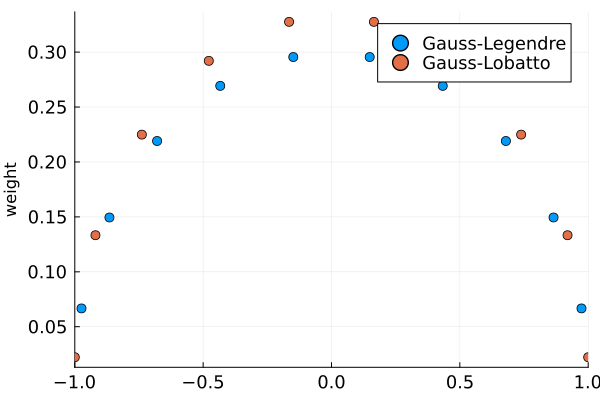

In [2]:
using Pkg
pkg"add FastGaussQuadrature"
using FastGaussQuadrature

n = 10
x, q = gausslegendre(n)
scatter(x, q, label="Gauss-Legendre", ylabel="weight", xlims=(-1, 1))
scatter!(gausslobatto(n)..., label="Gauss-Lobatto")

Other reading: [Trefethen, *Six Myths of Polynomial Interpolation and Quadrature*](https://people.maths.ox.ac.uk/trefethen/mythspaper.pdf)

In [21]:
@time gausslegendre(10_000_000);

  0.418783 seconds (16 allocations: 305.187 MiB, 64.74% gc time)


## Singular Integrands

What should we do when the integrand contains a singularity?

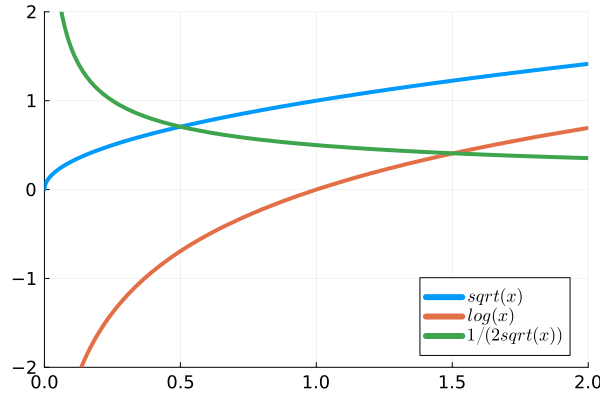

In [22]:
plot([sqrt log x->.5*x^(-.5)], xlim=(0, 2), ylim=(-2, 2), label=["\$sqrt(x)\$" "\$log(x)\$" "\$1/(2 sqrt(x))\$"])

Error is higher than we would expect with other functions.

In [23]:
function fint_gauss(f, a, b, n)
    x, w = gausslegendre(n)
    x = (a+b)/2 .+ (b-a)/2*x
    w *= (b - a)/2
    w' * f.(x)
end

fint_gauss (generic function with 1 method)

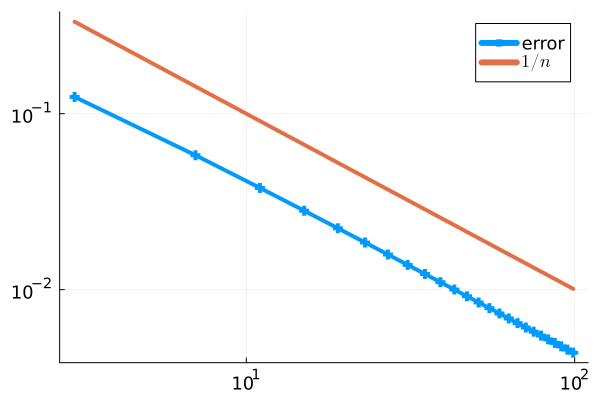

In [24]:
plot(3:4:100, 
    n -> abs(fint_gauss(x -> .5*x^(-.5), 0, 1, n) - 1),
    marker=:auto, yscale=:log10, xscale=:log10, label="error")
plot!(n -> 1/n, label="\$1/n\$")

## Tanh-Sinh quadrature

When functions have singularities near the endpoints, it is usually more efficient to integrate via a change of variables. 
Suppose we have a strictly monotone differentiiable function $\phi : \left( -\infty, \infty \right) \rightarrow \left( -1, 1 \right)$.
Then with $x = \phi \left( s \right)$, our integral transforms as

$$ \int_{-1}^1 f \left( x \right) \, dx = \int_{-\infty}^\infty f \left( \phi \left( s \right) \right) \phi ' \left( s \right) \, ds $$

The tanh-sinh method uses a transformation such that $\phi ' \left( s \right) \rightarrow 0$ faster than the singularity $f \left( \phi \left( s \right) \right)$ grows, such that the integrand goes to $0$ at finite $s$.

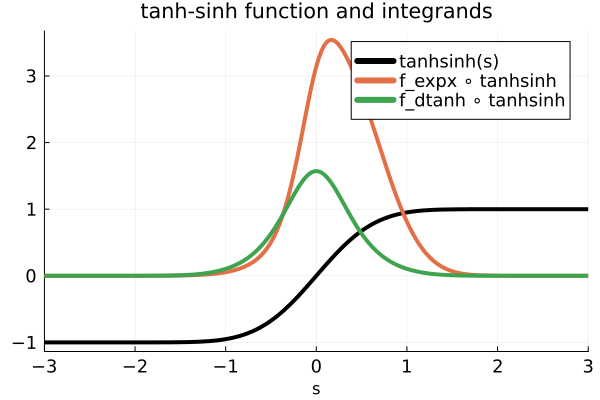

In [25]:
tanhsinh(s) = tanh(π/2*sinh(s))

# Here's the transformation
function dtanhsinh(s)
    ds = 1
    t = π/2 * sinh(s)
    dt = π/2 * cosh(s) * ds
    (1 - tanh(t)^2) * dt
end

# And lets plot the function and integrands
p = plot([tanhsinh], color=:black, label="tanhsinh(s)",
    xlims=(-3, 3),
    xlabel="s", title="tanh-sinh function and integrands")
for f in integrands
    plot!(s -> f(tanhsinh(s))*dtanhsinh(s), label="$f ∘ tanhsinh")
end
p

### Implementation

The function below implements tanh-sinh quadrature on the interval $\left( -1, 1 \right)$.
Given the number of points, we need to choose both the limits of integration (we can't afford to integrate all the way to infinity) and the spacing.
Here we make an arbitrary choice to integrate on the interval $\left( -L, L \right)$ where $L = \log \left( n \right)$.
The grid spacing thus scales as $h \approx 2 \log \left( n \right) / n$.

Modify the quadrature so it can be used to integrate on an arbitrary interval $\left( a, b \right)$.

In [26]:
function fint_tanhsinh(f, a, b; n=9)
    L = log(n)
    h = 2 * L / (n - 1)
    s = LinRange(-L, L, n)
    x = tanhsinh.(s)
    w = h * dtanhsinh.(s)
    ## Challenge: modify the weights w and points x to integrated on (a, b), not (-1, 1)
    w' * f.(x)
end

fint_tanhsinh (generic function with 1 method)

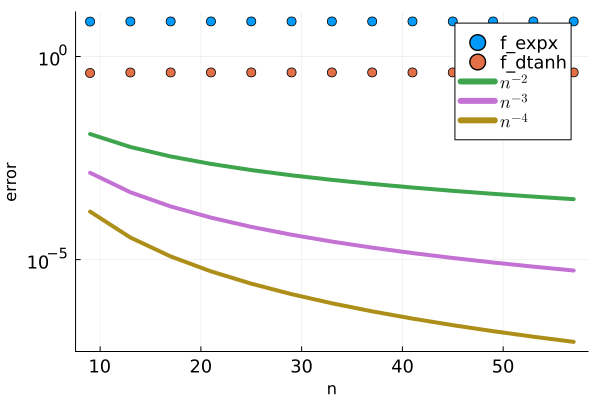

In [27]:
plot_accuracy(fint_tanhsinh, tests, 9:4:60, ref=[2,3,4])
plot!(xscale=:identity,)

In [10]:
# If you complete the challenge above
@assert fint_tanhsinh(log, 0, 1, n=20) ≈ -1
println("Tests pass")

LoadError: DomainError with -0.9999999999999508:
log was called with a negative real argument but will only return a complex result if called with a complex argument. Try log(Complex(x)).

## Finite Element methods

* Need to integrate the product of basis functions over every element

* Choose a quadrature (e.g. Gauss) to minimize number of points needed for sufficient accuracy

* Bad effects if insufficient points

## Rough/singularities in middle of domain

If a function has rough or singular behavior in the interior of the domain, we will get low accuracy results

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


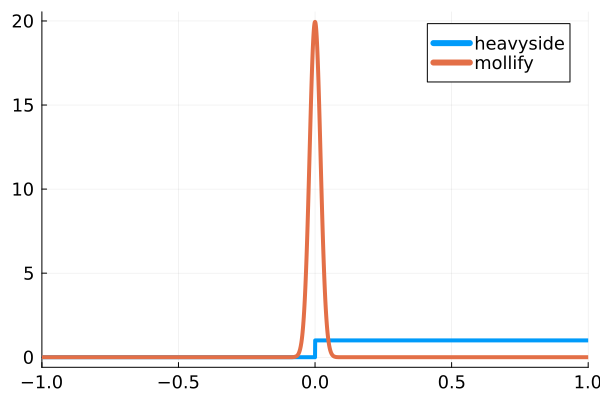

In [11]:
using Pkg
pkg"add SpecialFunctions"
using SpecialFunctions

f_heaviside(x) = 1.0 * (x > 0)
F_heaviside(x) = max(x, 0)
f_mollify(x, sigma=.02) = 1/(sigma * sqrt(2*π)) * exp(-.5*(x/sigma)^2)
F_mollify(x, sigma=.02) = .5*erf(x/(sigma*sqrt(2)))
rough_tests = [(f_heaviside, F_heaviside), (f_mollify, F_mollify)]
plot([f_heaviside, f_mollify], xlim=(-1, 1), label=["heavyside" "mollify"])

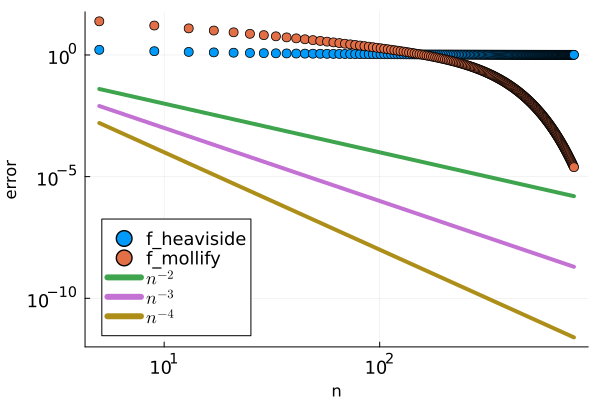

In [12]:
plot_accuracy(fint_tanhsinh, rough_tests, 5:4:800, ref=[2,3,4]); plot!(legend=:bottomleft)

## Adaptive integration

Adaptive integration is a process where we adaptively subdivide the integration into smaller pieces until the numerical integral converges.

In [28]:
using Pkg
pkg"add HCubature"
using HCubature

@show F_heaviside(1 - .3) - F_heaviside(-1 - .3)
hquadrature(x -> f_heaviside(x - 0.3), -1, 1, maxevals=1000)

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


F_heaviside(1 - 0.3) - F_heaviside(-1 - 0.3) = 0.7


(0.700000008169331, 9.264907000048497e-9)

In [14]:
hquadrature(f_mollify, -1, 1, maxevals=1000)

(1.0000000000000002, 6.773756033519694e-10)

In [15]:
F_mollify(1) - F_mollify(-1)

1.0

## Quadrature/cubature for multiple dimensions

Here is one such package: [quadpy](https://pypi.org/project/quadpy)